In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:\\Users\\Intel\\Documents\\Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [3]:

df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


In [5]:

df.fillna('unknown', inplace=True)
df.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [6]:
print(df['Label_1_Virus_category'].value_counts())
print('='*50)
print(df['Label_2_Virus_category'].value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


In [7]:

train_data = df[df['Dataset_type']=='TRAIN']
test_data = df[df['Dataset_type']=='TEST']
print('Train shape: ',train_data.shape)
print('Test Shape: ',test_data.shape)

Train shape:  (5286, 6)
Test Shape:  (624, 6)


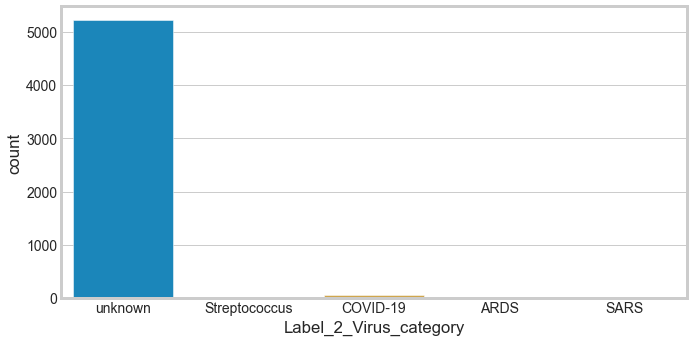

In [8]:

plt.figure(figsize=(10,5))
sns.countplot(train_data['Label_2_Virus_category']);


In [9]:

train_img_path = 'C:\\Users\\Intel\\Documents\\Coronahack-Chest-XRay-Dataset\\Coronahack-Chest-XRay-Dataset\\train'
test_img_path = 'C:\\Users\\Intel\\Documents\\Coronahack-Chest-XRay-Dataset\\Coronahack-Chest-XRay-Dataset\\test'

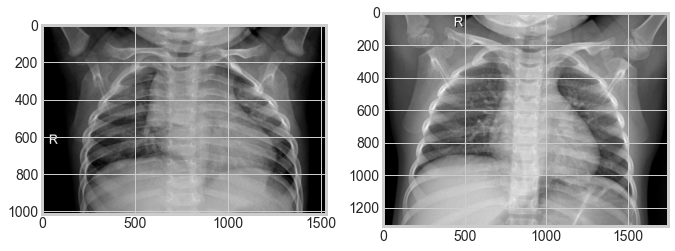

In [10]:

samp_img1 = Image.open(os.path.join(train_img_path, train_data['X_ray_image_name'][0]))
samp_img2 = Image.open(os.path.join(train_img_path, train_data['X_ray_image_name'][22]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1, cmap='gray');
ax[1].imshow(samp_img2, cmap='gray');


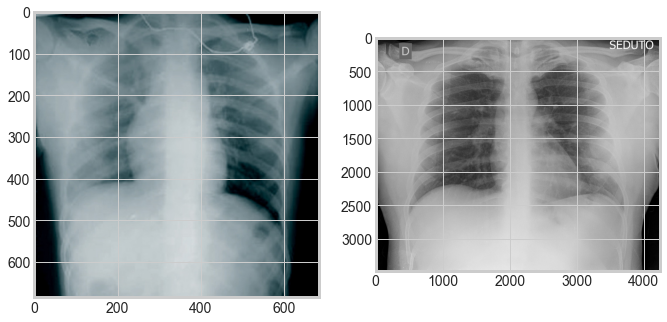

In [11]:

with_covid = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']


samp_img1 = Image.open(os.path.join(train_img_path, with_covid['X_ray_image_name'].iloc[8]))
samp_img2 = Image.open(os.path.join(train_img_path, with_covid['X_ray_image_name'].iloc[15]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1);
ax[1].imshow(samp_img2);

In [12]:

final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]

In [13]:
 
final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)

In [14]:

final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

In [15]:

datagen =  ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
)


def read_img(filename, size, path):
    img = image.load_img(os.path.join(path, filename), target_size=size)
    img = image.img_to_array(img) / 255
    return img


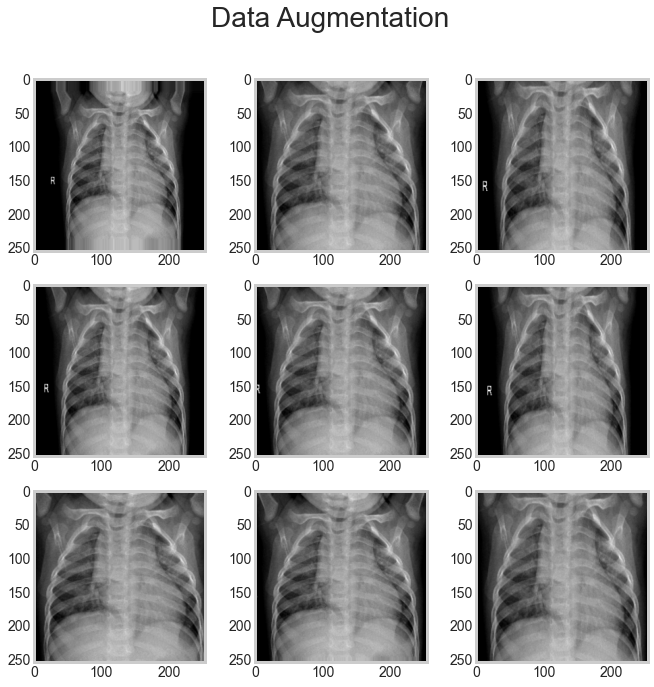

In [16]:

samp_img = read_img(final_train_data['X_ray_image_name'][0],
                                 (255,255),
                                 train_img_path)

plt.figure(figsize=(10,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0


for batch in datagen.flow(tf.expand_dims(samp_img,0), batch_size=6):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(255, 255, 3));
    
    if i == 8:
        break
    i += 1
    
plt.show();

In [17]:

corona_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'COVID-19']
with_corona_augmented = []


def augment(name):
    img = read_img(name, (255,255), train_img_path)
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(img, 0), batch_size=32)):
        with_corona_augmented.append(tf.squeeze(batch).numpy())
        if i == 20:
            break
        i =i+1


corona_df['X_ray_image_name'].apply(augment)

20it [00:00, 36.70it/s]              
20it [00:00, 41.15it/s]              
20it [00:00, 34.10it/s]              
20it [00:00, 33.70it/s]              
20it [00:00, 39.47it/s]              
20it [00:00, 42.75it/s]              
20it [00:00, 42.55it/s]              
20it [00:00, 43.35it/s]              
20it [00:00, 43.40it/s]              
20it [00:00, 42.20it/s]              
20it [00:00, 33.77it/s]              
20it [00:00, 41.73it/s]              
20it [00:00, 42.03it/s]              
20it [00:00, 42.07it/s]              
20it [00:00, 40.68it/s]              
20it [00:00, 37.97it/s]              
20it [00:00, 43.12it/s]              
20it [00:00, 42.78it/s]              
20it [00:00, 40.93it/s]              
20it [00:00, 42.38it/s]              
20it [00:00, 41.31it/s]              
20it [00:00, 34.04it/s]              
20it [00:00, 41.31it/s]              
20it [00:00, 43.37it/s]              
20it [00:00, 42.94it/s]              
20it [00:00, 39.00it/s]              
20it [00:00,

5221    None
5222    None
5223    None
5224    None
5225    None
5226    None
5227    None
5228    None
5229    None
5230    None
5237    None
5238    None
5239    None
5240    None
5242    None
5243    None
5244    None
5245    None
5246    None
5247    None
5248    None
5249    None
5250    None
5251    None
5252    None
5253    None
5254    None
5255    None
5256    None
5257    None
5258    None
5259    None
5260    None
5261    None
5262    None
5263    None
5264    None
5265    None
5266    None
5267    None
5268    None
5269    None
5270    None
5271    None
5272    None
5273    None
5274    None
5275    None
5276    None
5277    None
5278    None
5279    None
5280    None
5281    None
5282    None
5283    None
5284    None
5285    None
Name: X_ray_image_name, dtype: object

In [18]:

train_arrays = [] 
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (255,255), train_img_path)))
test_arrays = []
final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (255,255), test_img_path)))


5286    None
5287    None
5288    None
5289    None
5290    None
        ... 
5905    None
5906    None
5907    None
5908    None
5909    None
Name: X_ray_image_name, Length: 624, dtype: object

In [19]:
print(len(train_arrays))
print(len(test_arrays))

1400
624


In [20]:

y_train = np.concatenate((np.int64(final_train_data['target'].values), np.ones(len(with_corona_augmented), dtype=np.int64)))

In [ ]:
train_tensors = tf.convert_to_tensor(np.concatenate((np.array(train_arrays), np.array(with_corona_augmented))))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(final_test_data['target'].values)